# Modeling

# Notebook Intro

This is the last notebook.

In this notebook we will be:
1. Logistic Regression
2. Downsample Paid Loans
3. Logistic Regression
4. Random Forest
    - Tune Hyperparameters
    - Feature Importance
5. XGBoost
    - Tune Hyperparameters
    - Feature Importance
    
Our goal for modeling is to end up with the highest recall for defualt loans. This will come at a cost of some overall accuracy. We will be mentioning recall and precision throughout the notebook so here are definition for each:
- Recall: Out of all actual Default loans, how many is our model correctly predicting
- Precision: Out of all loans that our model predicts Default, how many are actually default
    
Due to the long run time of the grid searches, this notebook is run through an AWS Sagemaker Notebook Instance.

## General Imports

In [11]:
import re
import os

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000) 

# Load Model Ready Data

Let's load in our model ready CSV file.

In [13]:
# read accepted_ready csv
accepted_ready = pd.read_csv('accepted_ready.csv')

Let's take a look at the first 5 rows to make sure that the data looks good:

In [14]:
accepted_ready.head()

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_tl,num_il_tl,num_op_rev_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bc_limit,total_il_high_credit_limit,earliest_cr_years_ago,term,grade,emp_length,MORTGAGE,OWN,Not Verified,Source Verified,car,credit_card,debt_consolidation,housing,major_purchase,medical,other,small_business,whole,Individual,Cash,loan_status
0,3600.0,55000.0,5.91,0.0,675.0,1.0,0.0,2765.0,29.7,13.0,560.0,0.0,0.0,722.0,144904.0,0.0,0.0,148.0,3.0,3.0,1.0,4.0,2.0,2.0,5.0,3.0,4.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,2400.0,13734.0,12.0,36,2.0,10,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
1,24700.0,65000.0,16.06,1.0,715.0,4.0,0.0,21470.0,19.2,38.0,695.0,0.0,0.0,0.0,204396.0,0.0,0.0,113.0,2.0,2.0,4.0,2.0,0.0,5.0,17.0,6.0,20.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,79300.0,24667.0,16.0,36,2.0,10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0
2,20000.0,63000.0,10.78,0.0,695.0,0.0,0.0,7869.0,56.2,18.0,700.0,0.0,0.0,0.0,189699.0,0.0,0.0,125.0,14.0,14.0,5.0,101.0,0.0,2.0,4.0,6.0,4.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,6200.0,14877.0,15.0,60,1.0,10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
3,35000.0,110000.0,17.06,0.0,785.0,0.0,0.0,7802.0,11.6,17.0,675.0,0.0,0.0,0.0,301500.0,0.0,0.0,36.0,2.0,2.0,1.0,2.0,0.0,4.0,10.0,2.0,10.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,62500.0,18000.0,7.0,60,2.0,10,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
4,10400.0,104433.0,25.37,1.0,695.0,3.0,0.0,21929.0,64.5,35.0,700.0,0.0,0.0,0.0,331730.0,0.0,0.0,128.0,4.0,4.0,6.0,4.0,0.0,4.0,9.0,10.0,7.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,20300.0,88097.0,17.0,60,5.0,3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0


Data looks good and now we can check the shape make sure we still have no NULL values:

In [15]:
# sum of null values 
accepted_ready.isnull().sum().sum()

0

In [16]:
accepted_ready.shape

(1972940, 56)

All of our data looks good and we can move on to modeling.

# Prepare Data

Before running any models, we are going to prepare the data. We will be splitting into Train, Validation and Test, and then scaling the data using StandardScaler. This will transform our data to have a mean of 0 and standard deviation of 1.

## Train, Validation, Test Splits

Use Train-Test Split to first split the data into Remainder and Test. Then use Train-Test split again to split the Remainder into Train and Validation. The reason we do two sets of splitting is because we don't want any data leakage when optimizing our hyper parameters. Validation will be reserved for optimizing our models and then at the end, once we have our ideal model, we will test it on the Test set. The test set will be the data that none of the models have ever seen before.

In [17]:
# import Train Test Split
from sklearn.model_selection import train_test_split

# Instantiate X and y
X = accepted_ready.drop('loan_status', axis=1)
y = accepted_ready['loan_status']

# Remainder Test Split
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

# Validation Train Split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, stratify = y_rem, random_state=1)


When splitting the data, we use the parameter "stratify" to make sure that we retain the same proportion of each class in each set as we see in the full data.

## Scale the Data

Now we can scale the data. We will be fitting the scaler to the Train set and then transforming the Validation set. Scaling will be necessary when using PCA during our Logistic Regression.

In [18]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# instantiate, fit, transform standard scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)

X_val_ss = ss.transform(X_val)

Now that our data is fully prepared, we can move onto our first model.

# Logistic Regression

The first model that we are going to run is a base logistic regression. All parameters are going to be set to default except for max iterations. We are going to leave this number high as we had issues with our model not converging.

## Base Model

In [19]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_ss, y_val)}')

The train accuracy is: 0.9309023966955553
The Validation accuracy is: 0.9305917113376423


We got an accuracy on both Train and Validation of 93%. This means that the model is not over fitting. However, the data is very imbalanced so we expect our model to be good at predicting Paid loans and poor at predicting Defult loans. Let's take a look at the classification report.

### Evaluate

In [20]:
# import classification report
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_val, log_reg.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96    326101
           1       0.77      0.58      0.67     43826

    accuracy                           0.93    369927
   macro avg       0.86      0.78      0.81    369927
weighted avg       0.93      0.93      0.93    369927



We can see that our model is predicting 58% of all default loans correctly. The model also has a precision score of 77% which means that out of all the times that our model predicts a loan to be default, 77% of those are actually default. However, when it comes to paid loans, we are predicting 98% of them correctly. Due to the imbalance of our data, these are numbers that we expected.

We can look at the confusion matrix to see the actual values. 

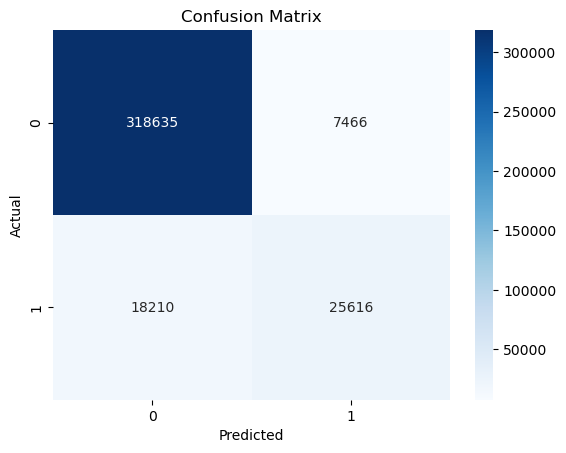

In [21]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# confusion matrix heatmap
cm = confusion_matrix(y_val, log_reg.predict(X_val_ss))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');


Our end goal is to have dark blue squares in the top left and bottom right. 

### Model Results

|     Model    | Downsampled Data? | Dimension Reduction? | Recall Default | Precision Default | Accuracy |
|:------------:|:-----------------:|:--------------------:|:--------------:|:-----------------:|:--------:|
| Log Reg |         No        |         None         |       58%      |        77%        |    93%   |

## Logistic Regression with PCA

Next we are going to run the logistic regression again but fit the model on a range of PCA components. PCA reduces the number of columns that we have by combining all of the features and giving them weights to see how important they are to our model. By giving higher and lower weights to features, PCA will also get rid of any multicollinearity in our model. We will be storing the training accuracy, validation accuracy, and explained variance into separate lists.

In [22]:
# Import PCA, LogisticRegression, and Accuracy Score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# range of n_components
n_components = range(1, 56, 5)

# Create empty list for train and test accuracy and explained variance
train_accuracy = []
validation_accuracy = []
expl_var = []

# Loop through n_components and fit PCA
for n in n_components:
    
    # print which component is being fit
    print(f'Fitting PCA with {n} components')
    
    # Instantiate and fit PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_ss)
    X_val_pca = pca.transform(X_val_ss)
    
    # Instantiate and fit PCA data to Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(X_train_pca, y_train)
    
    # Explained Variance
    ev = pca.explained_variance_ratio_.sum()
    
    # Evaluate the model
    train_accuracy.append(log_reg.score(X_train_pca, y_train))
    validation_accuracy.append(log_reg.score(X_val_pca, y_val))
    expl_var.append(ev)

Fitting PCA with 1 components
Fitting PCA with 6 components
Fitting PCA with 11 components
Fitting PCA with 16 components
Fitting PCA with 21 components
Fitting PCA with 26 components
Fitting PCA with 31 components
Fitting PCA with 36 components
Fitting PCA with 41 components
Fitting PCA with 46 components
Fitting PCA with 51 components


After running through a range of PCA components, we can re-evaluate our model.

### Evaluate

To evaluate the model, we are going to plot the training accuracy and validation accuracy against each other across the range of components, and then plot the explained variance across the range of PCA components. We want to see how the number of components we use effects our model.

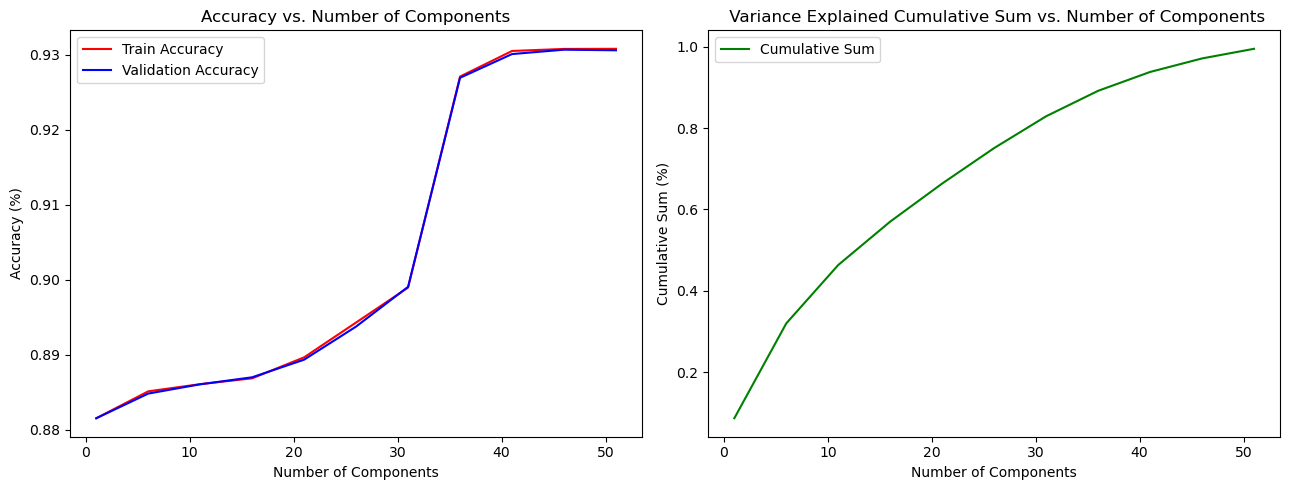

In [23]:
# create 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Accuracy vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components, train_accuracy, label='Train Accuracy', color='red')
plt.plot(n_components, validation_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (%)')
plt.legend()

# Cumulative Sum vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components, expl_var, label='Cumulative Sum', color='green')
plt.title(' Variance Explained Cumulative Sum vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum (%)')
plt.legend()

plt.tight_layout()
plt.show()

We can see that our training and validation accuracies are almost identical meaning that the model is not over fitting at any component. The accuracy starts around 88% with 1 component and goes up to a little over 93% for 51 components. If we look at the explained variance graph, we can see that there is a slight curve. We would like to keep 90% of explained variance in our model so we can go ahead and figure out which number of components does that for us. It looks to be around 35 components. We have tested 36 components so we are going to find out the train accuracy, validation accuracy and explained variance for 36 components.

In [24]:
# find accuracy at 36 components
print(f'The train accuracy is: {train_accuracy[7]}')
print(f'The Validation accuracy is: {validation_accuracy[7]}')

# find explained variance at 36 components
print(f'The explained variance is: {expl_var[7]}')


The train accuracy is: 0.927101636543525
The Validation accuracy is: 0.9269369362063326
The explained variance is: 0.8916745362648091


36 components gives us around 93% accuracy and has 89% explained variance. This is exactly what we were looking for. Now we can refit the model with 36 components and re-evaluate it.

## Logistic Regression with 36 PCA Components

In [25]:
# Instantiate and fit PCA
pca = PCA(n_components=36)
X_train_pca = pca.fit_transform(X_train_ss)
X_val_pca = pca.transform(X_val_ss)

# Instantiate and fit PCA data to Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_pca, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_pca, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_pca, y_val)}')

The train accuracy is: 0.9270682965421914
The Validation accuracy is: 0.9269126070819378


After fitting the model with 36 PCA components, our train and test accuracy is around 93%. This is the same as we got for our base model but with 36 feautures instead of 56 features. We can take a look at the classification report to see if there are any changes in the Recall and Precision Scores.

### Evaluate

In [26]:
# classification report
print(classification_report(y_val, log_reg.predict(X_val_pca)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96    326101
           1       0.77      0.55      0.64     43826

    accuracy                           0.93    369927
   macro avg       0.85      0.76      0.80    369927
weighted avg       0.92      0.93      0.92    369927



We can see that precision and accuracy have the same. The recall has slightly dropped by 3%. Although the overall percentages have remained similiar, PCA has gotten rid of any features that are not good predictors and our model also is more computationally efficient. We can take a look at the new confusion matrix.

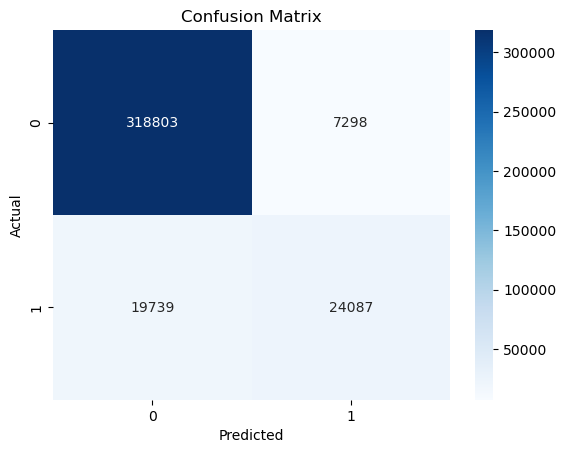

In [27]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# show heatmap confusion matrix
sns.heatmap(confusion_matrix(y_val, log_reg.predict(X_val_pca)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Model Results

|  Model  | Downsampled Data? | Dimension Reduction? | Hyperparameters | Recall Default | Precision Default | Accuracy |
|:-------:|:-----------------:|:--------------------:|:---------------:|:--------------:|:-----------------:|:--------:|
| Log Reg | No                | None                 | N/A             | 58%            | 77%               | 93%      |
| Log Reg | No                | PCA 36 Components    | N/A             | 55%            | 77%               | 93%      |

Our goal is to have high recall for Default loans. To get this number higher, we are going to have to downsample the Paid loans in order to balance out the data. We are going to downsample so that Default loans now take up 40% of the data instead of 12% like they did before.

# Downsample to 60/40

Find Current Distribution of `loan_status`:

In [28]:
# distribution of loan status
accepted_ready['loan_status'].value_counts()

0    1739202
1     233738
Name: loan_status, dtype: int64

Find current percentage distribution of `loan_status`:

In [29]:
# distribution of loan status percentages
accepted_ready['loan_status'].value_counts(normalize=True)

0    0.881528
1    0.118472
Name: loan_status, dtype: float64

We can see that our Default loans only take up 11.8% of our data. This is causing the model to have a difficult correctly prediciting.

To downsample where 40% of our data is class 1, we can multiply the number of observations in class 1 by 1.5 and get the corresponding amount we need in class 0. 

In [30]:
class1 = 233728
class0 = class1 * 1.5
print(class0)
print(class0 / (class1 + class0))
print(class1 / (class1 + class0))

350592.0
0.6
0.4


Now that we know we need 350592 data points in our Paid Loans (Class 0), we can use resample and specify this number.

In [31]:
# import resample
from sklearn.utils import resample

# sample 60% of class 1 and 100% of class 0
accepted_sample = resample(accepted_ready[accepted_ready['loan_status'] == 0], replace=True, n_samples=350592, random_state=1)

# concatenate class 0 and class 1
accepted_sample = pd.concat([accepted_ready[accepted_ready['loan_status'] == 1], accepted_sample])

# distribution of loan status
print(accepted_sample['loan_status'].value_counts())
print(accepted_sample['loan_status'].value_counts(normalize=True))

0    350592
1    233738
Name: loan_status, dtype: int64
0    0.59999
1    0.40001
Name: loan_status, dtype: float64


Let's plot out the distribution:

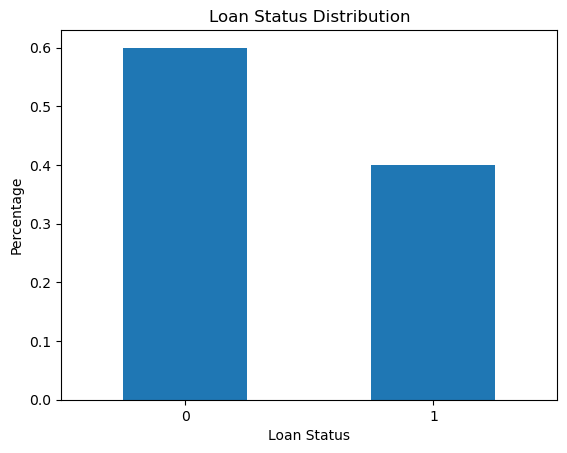

In [33]:
# plot percentage of loan status
accepted_sample['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status')
plt.ylabel('Percentage')
# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')
plt.show()

Now are data is roughly 60/40 split. Let's check the shape of our new data frame.

In [34]:
accepted_sample.shape

(584330, 56)

Instead of 1.97 million total rows, we now have close to 600 thousand. Downsampling will hopefully give us better recall on Default loans and will also speed up the run time of our models. 

# Accepted Sample Data to CSV

Let's write our sampled data to a new CSV.

In [35]:
# accepted sample to csv
accepted_sample.to_csv('accepted_sample.csv', index=False)

We can read in our sampled data and do a few sanity check to make sure that the shape of the data as well as the data types are looking good.

In [36]:
# read accepted_sample csv
accepted_sample = pd.read_csv('accepted_sample.csv')

In [37]:
accepted_sample.shape

(584330, 56)

In [38]:
accepted_sample.dtypes.value_counts()

float64    53
int64       3
dtype: int64

Everything looks good.

# Prepare Data

We are going to prepare our data the same way we did before, splitting it into Train, Validation and Test. Then we will scale the data using Standard Scaler again. 

## Train, Validation, Test Splits

In [39]:
# import Train Test Split
from sklearn.model_selection import train_test_split

# Instantiate X and y
X = accepted_sample.drop('loan_status', axis=1)
y = accepted_sample['loan_status']

# Remainder Test Split
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=1)

# Valudation Train Split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.25, stratify = y_rem, random_state=1)

As mentioned beofre, we are using stratify to get the same proportion of each class into each set of data.

## Scale the Data

In [40]:
# import standard scaler
from sklearn.preprocessing import StandardScaler

# instantiate, fit, transform standard scaler
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_val_ss = ss.transform(X_val)

We have our train and validation data and the data is now scaled, so let's re run our logistic regression model and compare the results to before.

# Logistic Regression

## Base Model

We are going to start off again by running a base model with no tweaks to the parameters.

In [41]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_ss, y_val)}')

The train accuracy is: 0.9053957436451313
The Validation accuracy is: 0.9071849728920611


Our overall accuracy has gone down slightly from 93% to around 91% but we can see that we are still not overfitting. Now let's evaluate the model using a classification report and confusion matrix to see if we have increased the recall on our Default loans. Since we have downsampled the Paid loans, we expect there to be a decrease in recall and precision for the Paid loans as there is less data for the model to learn off of.

### Evaluate

In [42]:
# classification report
print(classification_report(y_val, log_reg.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92     65736
           1       0.89      0.87      0.88     43826

    accuracy                           0.91    109562
   macro avg       0.90      0.90      0.90    109562
weighted avg       0.91      0.91      0.91    109562



Just from downsampling Paid loans, we have increased out recall on Default loans from 58% to 87% on our base model. Our Precision has increased from 77% to 89%. This is a large change in the number of defualt loans that our model is able to correctly predict. Let's run the model against the same number of PCA components and then re-evaluate. Similiar to before, PCA will reduce the number of features that we have and will speed up the run time of our model. 

### Model Results

|  Model  | Downsampled Data? | Dimension Reduction? | Hyperparameters | Recall Default | Precision Default | Accuracy |
|:-------:|:-----------------:|:--------------------:|:---------------:|:--------------:|:-----------------:|:--------:|
| Log Reg | No                | None                 | N/A             | 58%            | 77%               | 93%      |
| Log Reg | No                | PCA 41 Components    | N/A             | 55%            | 77%               | 93%      |
| Log Reg | Yes               | None                 | N/A             | 87%            | 89%               | 91%      |

## Logistic Regression with PCA

Similar to before, we will be using a range of 1-56 PCA components to test our model. We will be storing our train and validation accuracies as well as explained variance for each number of components.

In [43]:
# Import PCA, LogisticRegression, and Accuracy Score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# range of n_components
n_components = range(1, 56, 5)

# Create empty list for train and test accuracy and runtime
train_accuracy = []
validation_accuracy = []
expl_var = []

# Loop through n_components and fit PCA
for n in n_components:
    
    # print progess 
    print(f'Fitting PCA with {n} components')
    
    # Instantiate and fit PCA
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_ss)
    X_val_pca = pca.transform(X_val_ss)
    
    # Instantiate and fit PCA data to Logistic Regression
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(X_train_pca, y_train)
    
    # Explained Variance
    ev = pca.explained_variance_ratio_.sum()
    
    # Evaluate the model
    train_accuracy.append(log_reg.score(X_train_pca, y_train))
    validation_accuracy.append(log_reg.score(X_val_pca, y_val))
    expl_var.append(ev)

Fitting PCA with 1 components
Fitting PCA with 6 components
Fitting PCA with 11 components
Fitting PCA with 16 components
Fitting PCA with 21 components
Fitting PCA with 26 components
Fitting PCA with 31 components
Fitting PCA with 36 components
Fitting PCA with 41 components
Fitting PCA with 46 components
Fitting PCA with 51 components


### Evaluate

Let's plot the same graphs that we had above and see how the accuracy and explained variance changed over the course of the components.

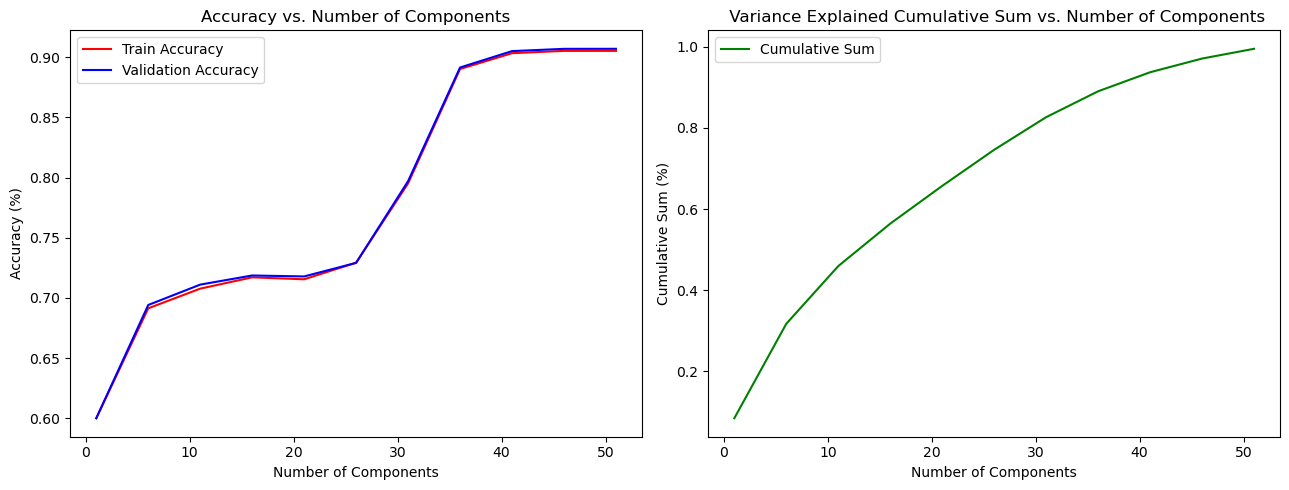

In [44]:
# Create 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# Accuracy vs. Number of Components
plt.subplot(1, 2, 1)
plt.plot(n_components, train_accuracy, label='Train Accuracy', color='red')
plt.plot(n_components, validation_accuracy, label='Validation Accuracy', color='blue')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy (%)')
plt.legend()

# Cumulative Sum vs. Number of Components
plt.subplot(1, 2, 2)
plt.plot(n_components, expl_var, label='Cumulative Sum', color='green')
plt.title(' Variance Explained Cumulative Sum vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum (%)')
plt.legend()

plt.tight_layout()
plt.show()

We can see that our train and validation accuracies are identical all the way through and that it starts around 60% and ends at just above 90%. The gap between 1 component and 51 components is much larger than before the down sample. This slight drop in accuracy make sense as we have less data for the model to learn off of. Looking to achieve 90% explained variance, the number of components looks to be 36 again. We can test this to make sure.

In [45]:
# find accuracy at 36 components
print(f'The train accuracy is: {train_accuracy[7]}')
print(f'The Validation accuracy is: {validation_accuracy[7]}')

# find explained variance at 36 components
print(f'The explained variance is: {expl_var[7]}')


The train accuracy is: 0.8902201195673669
The Validation accuracy is: 0.891458717438528
The explained variance is: 0.8902460816760208


We do get our desired explained variance percentage, however our accuracy for the model has gone down from 91% to about 90%. This is expected since the model has less overall data to learn from. Let's refit the model on 41 components and then take a look at the classification report and confusion matrix.

## Logistic Regression with 36 PCA Components

In [46]:
# Instantiate and fit PCA
pca = PCA(n_components=36)
X_train_pca = pca.fit_transform(X_train_ss)
X_val_pca = pca.transform(X_val_ss)

# Instantiate and fit PCA data to Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_pca, y_train)

# Evaluate the model
print(f'The train accuracy is: {log_reg.score(X_train_pca, y_train)}')
print(f'The Validation accuracy is: {log_reg.score(X_val_pca, y_val)}')

The train accuracy is: 0.8933690311392366
The Validation accuracy is: 0.8945802376736459


Our train and validation accuracies are both 89% so this means that our model is not overfitting. We have dropped 3% in accuracy from our last PCA model but we are expecting our recall to be much higher. Let's look at the classification report.

### Evaluate

In [47]:
# import classification report
from sklearn.metrics import classification_report

# show classification report
print(classification_report(y_val, log_reg.predict(X_val_pca)))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     65736
           1       0.88      0.85      0.87     43826

    accuracy                           0.89    109562
   macro avg       0.89      0.89      0.89    109562
weighted avg       0.89      0.89      0.89    109562



By using 36 features instead of 56, our recall has only dropped by 2% and our precision has only dropped by 1%. We can take a look at the confusion matrix to get a better idea of the numbers.

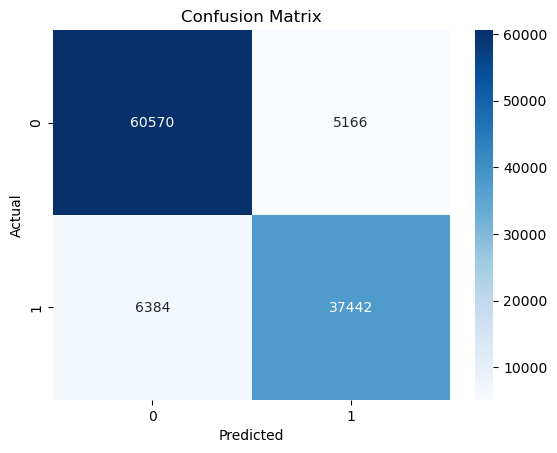

In [48]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# show heatmap confusion matrix
sns.heatmap(confusion_matrix(y_val, log_reg.predict(X_val_pca)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can see that compared to our Logistic Regression models before the down sample, the bottom right of the matrix has darkened significantly. Our model is missing a similar number of both classes now.

### Model Results

|  Model  | Downsampled Data? | Dimension Reduction? | Hyperparameters | Recall Default | Precision Default | Accuracy |
|:-------:|:-----------------:|:--------------------:|:---------------:|:--------------:|:-----------------:|:--------:|
| Log Reg | No                | None                 | N/A             | 58%            | 77%               | 93%      |
| Log Reg | No                | PCA 36 Components    | N/A             | 55%            | 77%               | 93%      |
| Log Reg | Yes               | None                 | N/A             | 87%            | 89%               | 91%      |
| Log Reg | Yes               | PCA 36 Components    | N/A             | 85%            | 88%               | 89%      |

We started our logistic regression model with a recall of 58% for Default loans. Just by downsampling the data to a 60/40 split, we saw a 29% increase in recall and a 12% increase in precision. This is a large change for just a 2% drop in overall accuracy. We can see that for both models, using PCA slightly decreased our Recall. Let's try other models.

# Random Forest

The next model we are going to run is Random Forest. Random Forest is a combination of decision trees that will all see different portions of the data and come together to form a final prediction. We do not need to use PCA for this model because it is not affected by highly correlated variables. Let's start out by running a base model and see what scores we get:

## Base Model

In [49]:
# import random forest
from sklearn.ensemble import RandomForestClassifier

# Instantiate and fit Random Forest on scaled data
rf = RandomForestClassifier()
rf.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {rf.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {rf.score(X_val_ss, y_val)}')

The train accuracy is: 0.9999878302934421
The Validation accuracy is: 0.9145506653766817


We can see that our base model is overfitting. This is noticeable due to the 8% gap between train and validation accuracy and a training accuracy of nearly 100%. Let's take a look at the classification report and confusion matrix for this model. 

### Evaluate

In [50]:
# classification report
print(classification_report(y_val, rf.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     65736
           1       0.88      0.91      0.89     43826

    accuracy                           0.91    109562
   macro avg       0.91      0.91      0.91    109562
weighted avg       0.92      0.91      0.91    109562



We can see that our recall for default loans has increased by 4% from our Logistic Regression Model. However, we cannot take this number seriously as our model is overfitting. We can take a look at the confusion matrix.

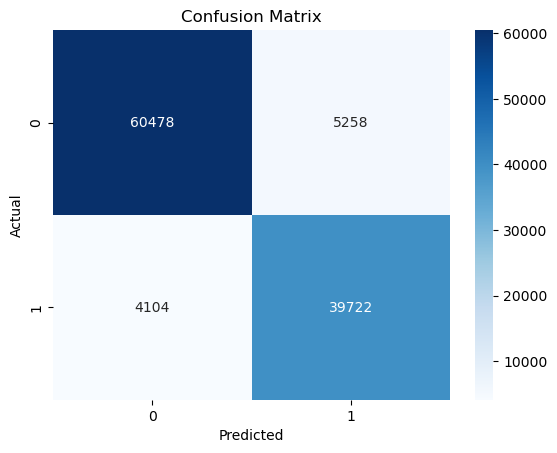

In [51]:
# confusion matrix
sns.heatmap(confusion_matrix(y_val, rf.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

There are very few loans that our model is predicting wrong but since we notice that it is overfitting, we need to optimize some of the hyperparameters.

### Model Results

|     Model     | Downsampled Data? | Dimension Reduction? | Hyperparameters | Recall Default | Precision Default | Accuracy | Notes          |
|:-------------:|:-----------------:|:--------------------:|:---------------:|:--------------:|:-----------------:|:--------:|----------------|
| Log Reg       | No                | None                 | N/A             | 58%            | 77%               | 93%      |                |
| Log Reg       | No                | PCA 36 Components    | N/A             | 55%            | 77%               | 93%      |                |
| Log Reg       | Yes               | None                 | N/A             | 87%            | 89%               | 91%      |                |
| Log Reg       | Yes               | PCA 36 Components    | N/A             | 85%            | 88%               | 89%      |                |
| Random Forest | Yes               | None                 | N/A             | 91%            | 88%               | 91%      | Overfitting 8% |

## Optimize Hyperparameters

To optimize our model, we are going to be focusing on three main parameters: 
- Number of trees
- The max depth of each tree
- The minimum number of points needed to split further

From researching Random Forest tuning and using our own knowledge, we have come up with suitable ranges for each parameter. We will be performing a 5 fold cross validation grid search and looking for the highest recall. 

We will be importing a package called `pickle` which will allow us to save our model. Saving our model in a pickle file will save us the time of having to re train the model. We will also be able to easily share our models. 

In [52]:
# import pickle
import pickle

In [54]:
# import grid search and pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score

# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])

# parameters
params = {
    'rf__n_estimators': range(30, 250, 30),
    'rf__max_depth': range(3, 9, 2),
    'rf__min_samples_split': range(2, 10, 2),
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2, refit=False, scoring = 'recall')
grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=30; total time=   6.3s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=30; total time=   6.4s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=30; total time=   6.4s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=30; total time=   7.2s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=30; total time=   7.8s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=60; total time=  13.2s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=60; total time=  13.7s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=60; total time=  14.6s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=60; total time=  13.2s
[CV] END rf__max_depth=3, rf__min_samples_split=2, rf__n_estimators=60; total time=  13.6s
[CV] END rf__max_depth=3, rf

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': range(3, 9, 2),
                         'rf__min_samples_split': range(2, 10, 2),
                         'rf__n_estimators': range(30, 250, 30)},
             refit=False, scoring='recall', verbose=2)

Get the best parameters from our grid search:

In [57]:
# best parameters
grid.best_params_

{'rf__max_depth': 7, 'rf__min_samples_split': 8, 'rf__n_estimators': 210}

Out of the best parameters that we got, we have the highest max_depth that we inputted and the highest number of estimators that we inputted.

Save the grid to a pickle file:

In [58]:
# save grid search to pickle file
pickle.dump(grid, open('rf_grid.pkl', 'wb'))

### Fit Best Parameters

Now we can fit our best parameters to a new Random Forest model and see if we are still overfitting:

In [59]:
# Instantiate and fit Random Forest on scaled data
rf = RandomForestClassifier(n_estimators=210, max_depth=7, min_samples_split=8)
rf.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {rf.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {rf.score(X_val_ss, y_val)}')

The train accuracy is: 0.9032356207310951
The Validation accuracy is: 0.9047023603074058


Our model has a train and validation accuracy of 90% and is no longer overfitting. Let's take a look at the classification report.

### Evaluate

In [60]:
# classification report
print(classification_report(y_val, rf.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     65736
           1       0.86      0.91      0.88     43826

    accuracy                           0.90    109562
   macro avg       0.90      0.90      0.90    109562
weighted avg       0.91      0.90      0.91    109562



We can see that our recall score for defualt loans is the exact same as our base model at 91%. Our precision has gone down 2% to 86 and our accuracy has gone down 1% to 90%. Overall, the model has the recall that we are looking for without overfitting.

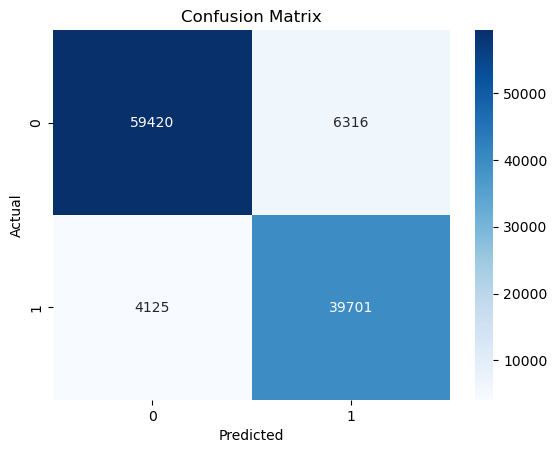

In [61]:
# confusion matrix
sns.heatmap(confusion_matrix(y_val, rf.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Feature Importance

Let's take a look at what features are contributing the most to our model.

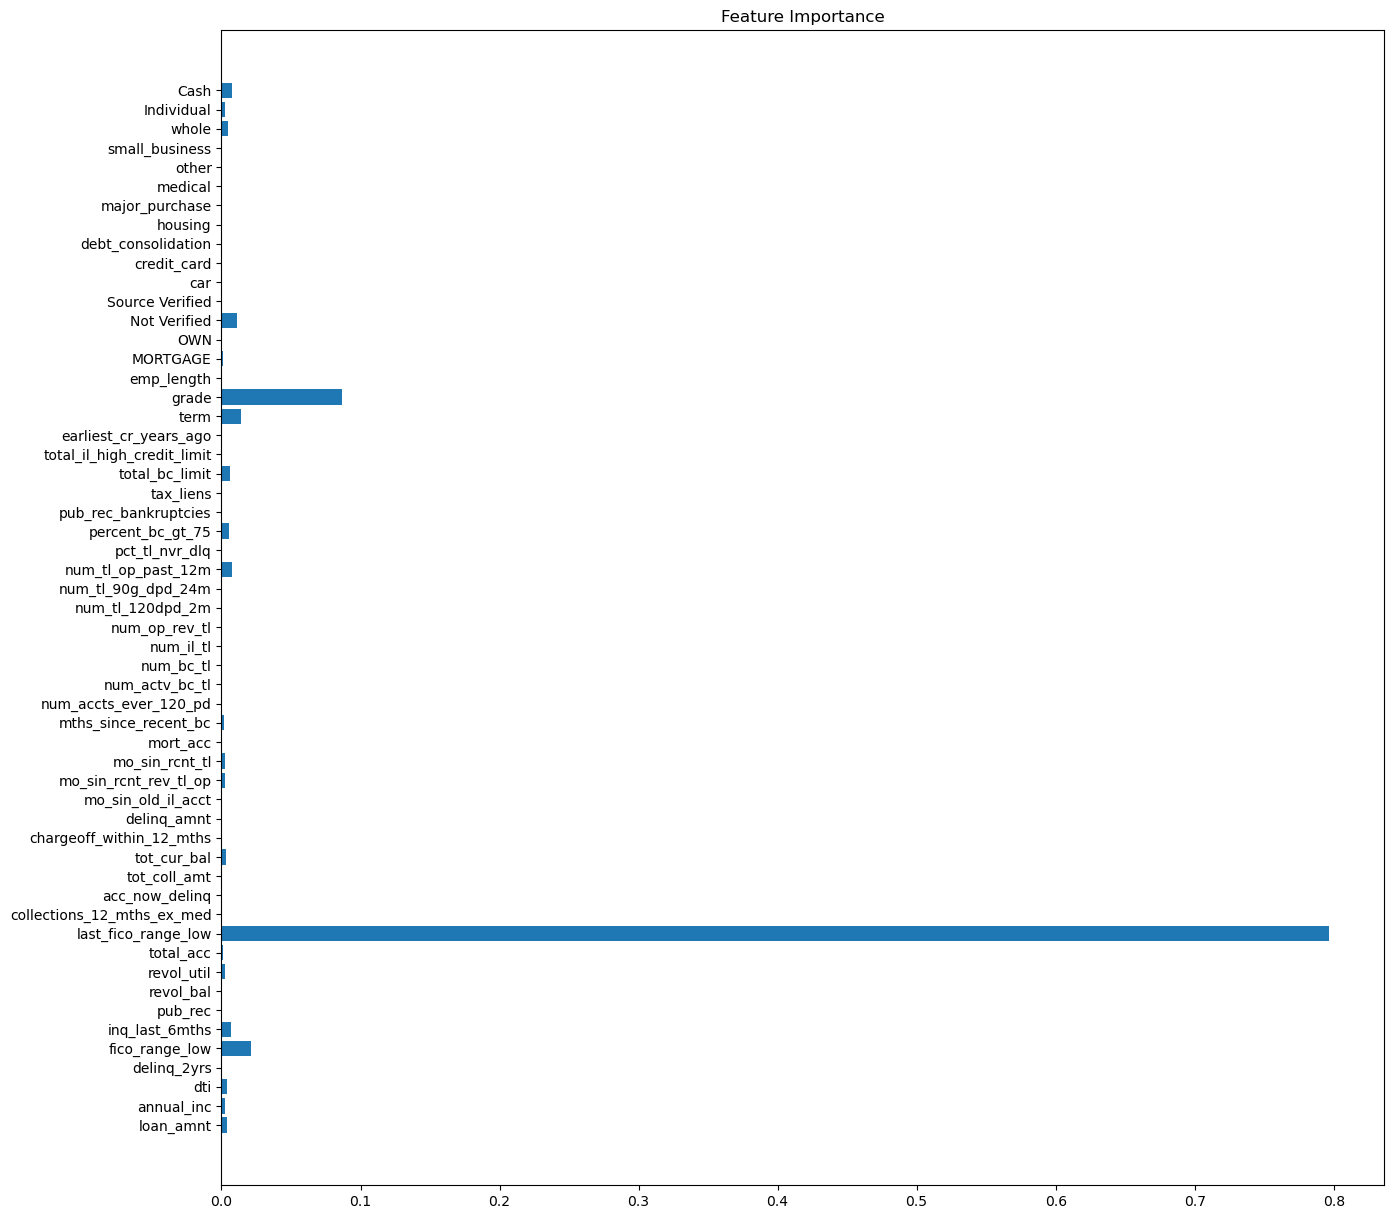

In [62]:
# plot feature importance
plt.figure(figsize=(15, 15))
plt.barh(X.columns, rf.feature_importances_)
plt.title('Feature Importance')
plt.show()

Looking at the feature importance, our Random Forest Model is mostly using `last_fico_range_low` and `grade` to predict Default loans. In a real world sense, this makes perfect sense as credit history and how risky that customer is to give a loan is a large factor in the outcome of a specific loan. However, `dti` and `loan_amnt` are two features that we thought would be used more. 

### Model Results

|     Model     | Downsampled Data? | Dimension Reduction? |                   Hyperparameters                  | Recall Default | Precision Default | Accuracy | Notes                                       |
|:-------------:|:-----------------:|:--------------------:|:--------------------------------------------------:|:--------------:|:-----------------:|:--------:|---------------------------------------------|
| Log Reg       | No                | None                 | N/A                                                | 58%            | 77%               | 93%      |                                             |
| Log Reg       | No                | PCA 36 Components    | N/A                                                | 55%            | 77%               | 93%      |                                             |
| Log Reg       | Yes               | None                 | N/A                                                | 87%            | 89%               | 91%      |                                             |
| Log Reg       | Yes               | PCA 36 Components    | N/A                                                | 85%            | 88%               | 89%      |                                             |
| Random Forest | Yes               | None                 | N/A                                                | 91%            | 88%               | 91%      | Overfitting 8%                              |
| Random Forest | Yes               | None                 | n_estimators=210, max_depth=7, min_samples_split=8 | 91%            | 86%               | 90%      | 5 fold CV, scoring = recall, No Overfitting |

# XG Boost

Our Random Forest Model had good results, but instead of combining various decision trees to make a prediction, we want to use the errors from one tree and input them into the next tree. This can be done using XG Boost models. In theory, this should give us a better result than Random Forest did. 

We are going to go through the same process that we did with Random Forest. First we will test a base model, then we will optimize hyperparameters of our choice so that we can potentially improve on that result.

## Base Model

Install XGBoost using pip since we are using AWS Sagemaker.

In [ ]:
# %pip install XGBoost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


We have installed XGBoost so now we can run a base model:

In [63]:
# import xgboost
from xgboost import XGBClassifier

# Instantiate and fit XGBoost on scaled data
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {xgb.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {xgb.score(X_val_ss, y_val)}')

/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[02:25:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train accuracy is: 0.9183108447297564
The Validation accuracy is: 0.9114108906372648


After running our base XGBoost model, we have achieved train and validation accuracies of 91%. The model is not overfitting and this is a 1% improvement from our optimized Random Forest model. Let's take a look at the classification report and confusion matrix.

### Evaluate

In [64]:
# import classification report
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_val, xgb.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     65736
           1       0.88      0.91      0.89     43826

    accuracy                           0.91    109562
   macro avg       0.91      0.91      0.91    109562
weighted avg       0.91      0.91      0.91    109562



Looking at the classification report, we are getting the same recall that we did with our optimized Random Forest Model. Our precision is 2% higher than our Random Forest model and our Accuracy is 1% higher. Overall, this is a slight improvement. 

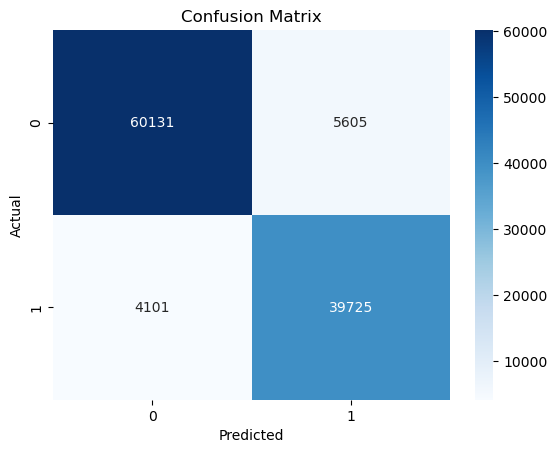

In [65]:
# confusion matrix heatmap
sns.heatmap(confusion_matrix(y_val, xgb.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Feature Importance

Let's take a look at the most prominent features in our predictions and see if they are any different from our Random Forest Model.

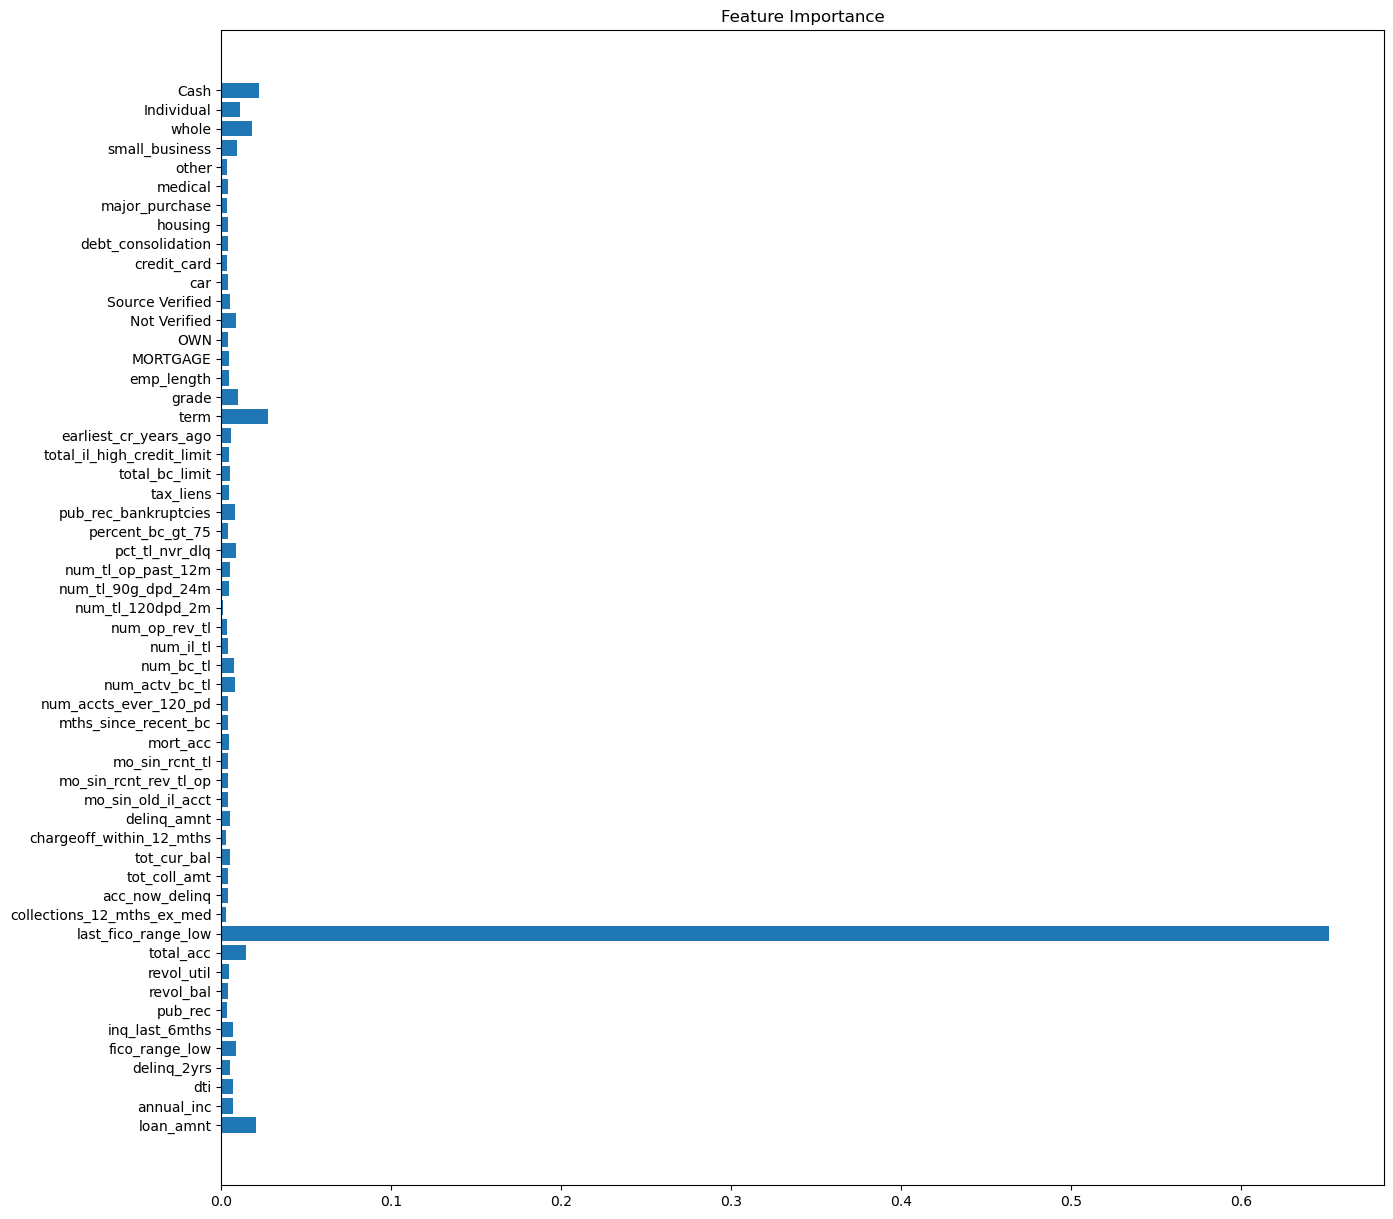

In [66]:
# plot feature importance
plt.figure(figsize=(15, 15))
plt.barh(X.columns, xgb.feature_importances_)
plt.title('Feature Importance')
plt.show()

It looks like XGBoost is using all of the features to some extent while Random Forest was not using the majority of features. We can also see that XGBoost is using `last_fico_range_low` about 15% less than Random Forest was. The top 5 features this model is using is `last_fico_range_low`, `term`, `cash`, `loan_amnt` and `whole`. 

Last FICO range low is the borrowers last low FICO score, term is how long is the repayment timeline, cash is how the loan is going to given to the borrower, loan amount is how much was requested, and whole means that the loan was a whole loan and not a fractional one.

All of these features make sense as predictors except for `cash` because cash took up most of the loans instead of directpay.

### Model Results

|     Model     | Downsampled Data? | Dimension Reduction? |                   Hyperparameters                  | Recall Default | Precision Default | Accuracy | Notes                                       |
|:-------------:|:-----------------:|:--------------------:|:--------------------------------------------------:|:--------------:|:-----------------:|:--------:|---------------------------------------------|
| Log Reg       | No                | None                 | N/A                                                | 58%            | 77%               | 93%      |                                             |
| Log Reg       | No                | PCA 36 Components    | N/A                                                | 55%            | 77%               | 93%      |                                             |
| Log Reg       | Yes               | None                 | N/A                                                | 87%            | 89%               | 91%      |                                             |
| Log Reg       | Yes               | PCA 36 Components    | N/A                                                | 85%            | 88%               | 89%      |                                             |
| Random Forest | Yes               | None                 | N/A                                                | 91%            | 88%               | 91%      | Overfitting 8%                              |
| Random Forest | Yes               | None                 | n_estimators=120, max_depth=7, min_samples_split=4 | 91%            | 86%               | 90%      | 5 fold CV, scoring = recall, No Overfitting |
| XGBoost       | Yes               | None                 | N/A                                                | 91%            | 88%               | 91%      |                                             |

## Optimize Hyperparameters

Next we are going to tune some of the hyperparameters. We are going to be looking at 5 main parameters:
- Booster Type
- Learning Rate
- Number of Trees
- Subsample percentage 
- Max Depth

As this gridsearch will be computationally heavy, we are going to start by testing a wide range of parameters, evaluate the results, and then go more in depth closer to the the best parameters that we get.

In [68]:
# import grid search and pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier(use_label_encoder=False))
])

# parameters
params = {
    'xgb__booster': ['dart'],
    'xgb__learning_rate':[0.1],
    'xgb__n_estimators': [150,200,250],
    'xgb__subsample': [0.7,0.9],
    'xgb__max_depth':[5,7]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2, refit=False, scoring='recall')
grid.fit(X_rem, y_rem)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas

[02:38:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.9; total time=11.7min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.7; total time=11.7min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.7; total time=11.7min
[02:49:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.9; total time=11.8min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.9; total time=11.8min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.7; total time=11.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.7; total time=11.8min
[02:49:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:49:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[02:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:49:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:49:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:49:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=150, xgb__subsample=0.9; total time=11.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:01:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.7; total time=19.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.9; total time=19.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:09:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.7; total time=19.4min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.7; total time=19.3min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.7; total time=19.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.7; total time=19.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:09:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:09:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:20:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.9; total time=19.1min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:20:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.9; total time=18.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.9; total time=18.9min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:27:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:27:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.7; total time=28.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.7; total time=28.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:37:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.7; total time=28.4min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.7; total time=28.4min
[03:37:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:37:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:37:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.7; total time=28.0min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:48:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.9; total time=28.1min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:48:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.7; total time=13.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:51:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.7; total time=13.9min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:51:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.9; total time=28.2min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.9; total time=28.2min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[03:56:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:56:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.7; total time=13.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:02:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.7; total time=13.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:02:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.7; total time=13.9min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.9; total time=13.8min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:05:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:05:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.9; total time=28.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=250, xgb__subsample=0.9; total time=28.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:05:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:05:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.9; total time=14.0min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:10:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.9; total time=14.1min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:10:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.9; total time=14.1min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:16:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=150, xgb__subsample=0.9; total time=14.0min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:16:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.7; total time=22.5min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.7; total time=22.6min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:27:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:27:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.7; total time=22.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:28:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.7; total time=22.5min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:28:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.7; total time=22.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:32:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.9; total time=22.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:32:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.9; total time=22.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:38:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.9; total time=22.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:38:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.9; total time=22.3min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:50:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.9; total time=22.4min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[04:50:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.7; total time=32.7min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[05:01:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.7; total time=32.9min


/Users/devenpatel/opt/anaconda3/envs/capstone/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[05:01:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.7; total time=32.7min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.7; total time=32.8min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.9; total time=31.3min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.7; total time=31.5min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=250, xgb__subsample=0.9; total time=25.8min
[CV] END xgb__booster=dart, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      mon...
                                                      reg_alpha=None,
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      use_label_encoder=False,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'xgb__booster': ['dart'], 'xgb__learning_rate': [0.1],
                         'xgb__max_depth': [5, 7],
                         'xgb__n_estimators': [150, 200, 250],
                         'xgb__subsample': [0.7, 0.9]},
             refit=False, scoring='recall', verbose=2)

Model run time = 3 hours

Get best parameters from the grid search:

In [69]:
# best parameters
grid.best_params_

{'xgb__booster': 'dart',
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.7}

Save the grid to a pickle file:

In [70]:
# save grid search to pickle file
pickle.dump(grid, open('XGB_grid1.pkl', 'wb'))

### Fit Best Parameters

Now that we have our best parameters, we can fit them to a new XGBoost model.

In [71]:
# Instantiate and fit XGBoost on scaled data
xgb = XGBClassifier(booster='dart', learning_rate=0.1, n_estimators=200, subsample=0.7, max_depth=7, use_label_encoder=False)
xgb.fit(X_train_ss, y_train)

# Evaluate the model
print(f'The train accuracy is: {xgb.score(X_train_ss, y_train)}')
print(f'The Validation accuracy is: {xgb.score(X_val_ss, y_val)}')

[07:54:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train accuracy is: 0.9208756103868445
The Validation accuracy is: 0.9120497982877275


We can see that our optimized model actually ended up with the same results as our base model. Let's take a look at the classification report to see if the recall and precision have changed:

### Evaluate

In [72]:
# import classification report
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_val, xgb.predict(X_val_ss)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     65736
           1       0.88      0.91      0.89     43826

    accuracy                           0.91    109562
   macro avg       0.91      0.91      0.91    109562
weighted avg       0.91      0.91      0.91    109562



The numbers for default loans are exactly the same and so is overall accuracy. The only difference we are seeing is a 1% increase in Paid loans recall. This is the highest combination of Paid and Default loan percentages out of all of our models. Let's look at the confusion matrix to see the numbers.

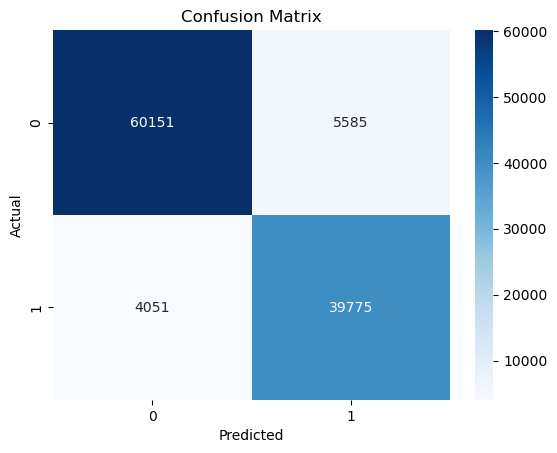

In [73]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# confusion matrix
sns.heatmap(confusion_matrix(y_val, xgb.predict(X_val_ss)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the previous model, we have predicted slightly more default loans correctly and have also predicted slightly more paid loans. However, both of these increases are below 100 loans. 

### Feature Importance

Let's take a look at the features being used:

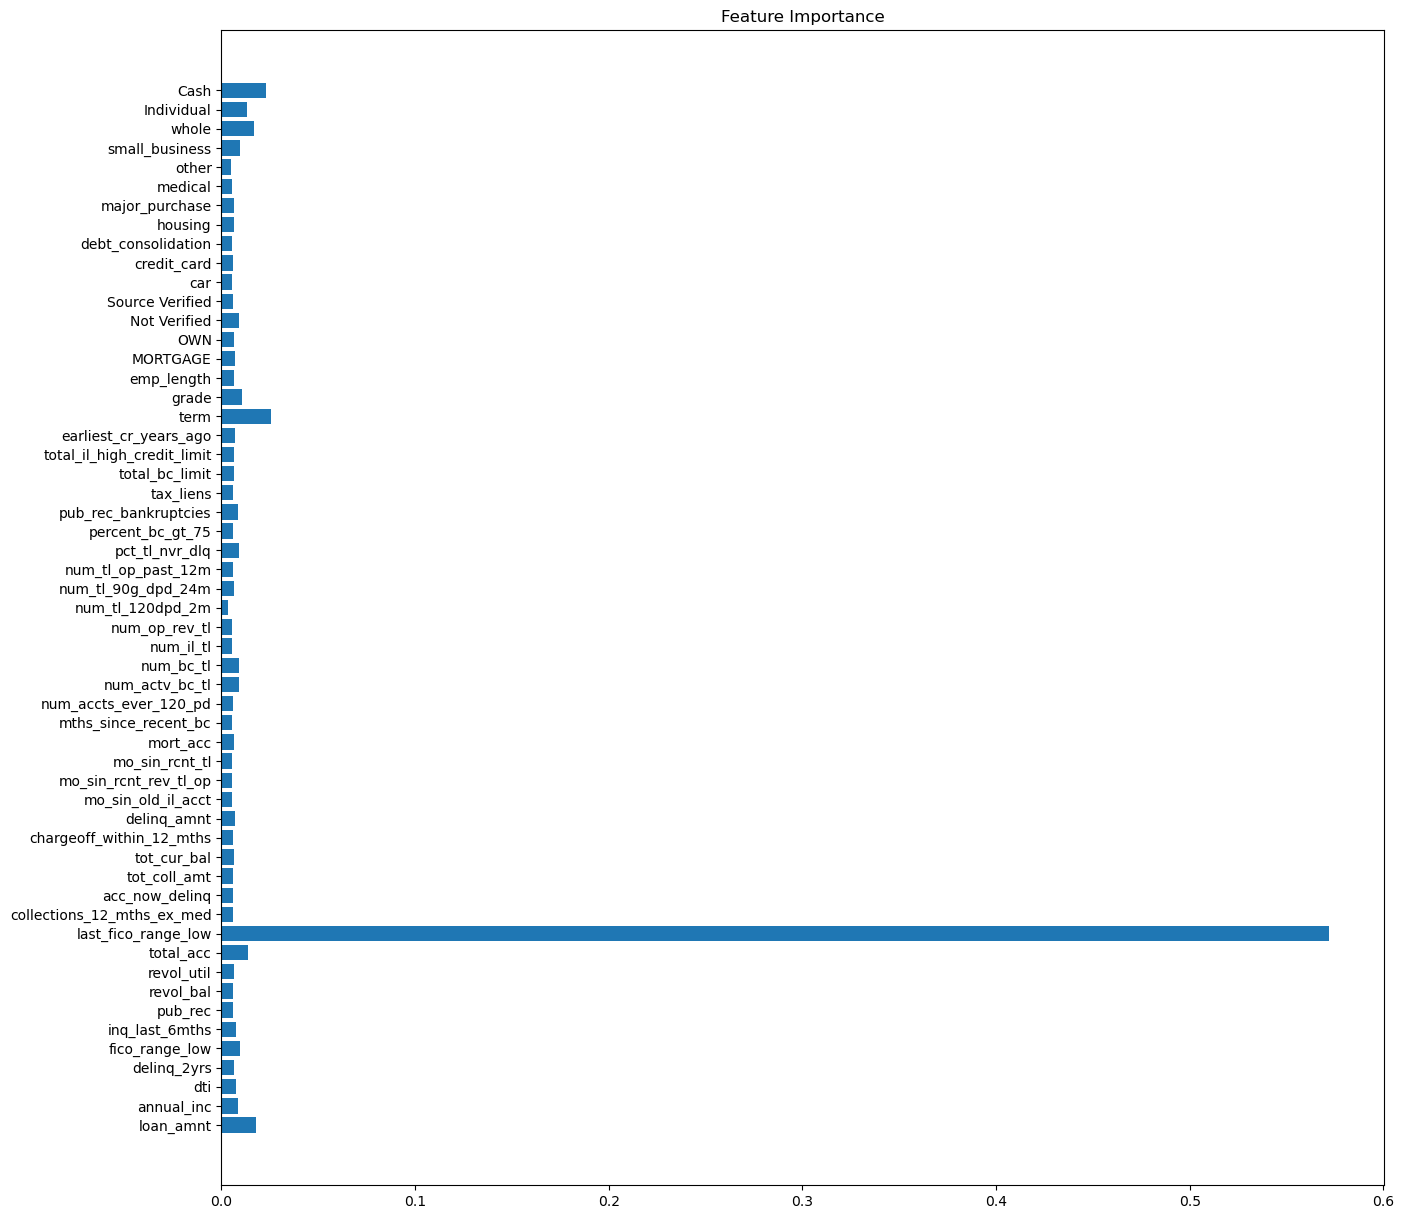

In [74]:
# plot feature importance
plt.figure(figsize=(15, 15))
plt.barh(X.columns, xgb.feature_importances_)
plt.title('Feature Importance')
plt.show()

The chart is identical to our base model. 

### Model Results

|     Model     | Downsampled Data? | Dimension Reduction? |                                  Hyperparameters                                 | Recall Default | Precision Default | Accuracy | Notes                                             |
|:-------------:|:-----------------:|:--------------------:|:--------------------------------------------------------------------------------:|:--------------:|:-----------------:|:--------:|---------------------------------------------------|
| Log Reg       | No                | None                 | N/A                                                                              | 58%            | 77%               | 93%      |                                                   |
| Log Reg       | No                | PCA 36 Components    | N/A                                                                              | 58%            | 77%               | 93%      |                                                   |
| Log Reg       | Yes               | None                 | N/A                                                                              | 87%            | 89%               | 91%      |                                                   |
| Log Reg       | Yes               | PCA 36 Components    | N/A                                                                              | 85%            | 88%               | 89%      |                                                   |
| Random Forest | Yes               | None                 | N/A                                                                              | 91%            | 88%               | 91%      | Overfitting 8%                                    |
| Random Forest | Yes               | None                 | n_estimators=120, max_depth=7, min_samples_split=4                               | 91%            | 86%               | 90%      | 5 fold CV,  scoring = recall No Overfitting       |
| XGBoost       | Yes               | None                 | N/A                                                                              | 91%            | 88%               | 91%      |                                                   |
| XGBoost       | Yes               | None                 | booster='dart', learning_rate=0.1,  n_estimators=200, max_depth=7, subsample=0.7 | 91%            | 88%               | 91%      | Highest precision/recall for Paid loans(94%, 92%) |

## Test best model on test data

Since our optimized model remained the same recall and precision for default loans but slightly increased for paid loans, we are going to use this as our final model. Let's re fit a XGBoost model but now we can use our test data set that has been untouched throughout this whole process. Instead of train and test, we will be using the remainder(combo of train and validation) to train the model and the test set to test the model. 

In [78]:
# transform remainder and test data standard scaler
X_test_ss = ss.transform(X_test)
X_rem_ss = ss.transform(X_rem)

# # Instantiate and fit XGBoost on scaled data
xgb = XGBClassifier(booster='dart', learning_rate=0.1, n_estimators=200, subsample=0.7, max_depth=7, use_label_encoder=False)
xgb.fit(X_rem_ss, y_rem)

# Evaluate the model
print(f'The train accuracy is: {xgb.score(X_rem_ss, y_rem)}')
print(f'The Validation accuracy is: {xgb.score(X_test_ss, y_test)}')

[08:06:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The train accuracy is: 0.9192076614329362
The Validation accuracy is: 0.9125428694646194


This is data that our model has never seen before but we have gotten exactly the same results as our optimized model.

### Evaluate

Let's take a look at the classification report to see if anything has changed. 

In [79]:
# classification report
print(classification_report(y_test, xgb.predict(X_test_ss)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     87648
           1       0.88      0.91      0.89     58435

    accuracy                           0.91    146083
   macro avg       0.91      0.91      0.91    146083
weighted avg       0.91      0.91      0.91    146083



We are getting exactly the same percentages across the board. 

# All Model Results

|     Model     | Downsampled Data? | Dimension Reduction? |                                  Hyperparameters                                 | Recall Default | Precision Default | Accuracy | Notes                                              |
|:-------------:|:-----------------:|:--------------------:|:--------------------------------------------------------------------------------:|:--------------:|:-----------------:|:--------:|----------------------------------------------------|
| Log Reg       | No                | None                 | N/A                                                                              | 58%            | 77%               | 93%      |                                                    |
| Log Reg       | No                | PCA 36 Components    | N/A                                                                              | 58%            | 77%               | 93%      |                                                    |
| Log Reg       | Yes               | None                 | N/A                                                                              | 87%            | 89%               | 91%      |                                                    |
| Log Reg       | Yes               | PCA 36 Components    | N/A                                                                              | 85%            | 88%               | 89%      |                                                    |
| Random Forest | Yes               | None                 | N/A                                                                              | 91%            | 88%               | 91%      | Overfitting 8%                                     |
| Random Forest | Yes               | None                 | n_estimators=120, max_depth=7, min_samples_split=4                               | 91%            | 86%               | 90%      | 5 fold CV,  scoring = recall No Overfitting        |
| XGBoost       | Yes               | None                 | N/A                                                                              | 91%            | 88%               | 91%      |                                                    |
| XGBoost       | Yes               | None                 | booster='dart', learning_rate=0.1,  n_estimators=200, max_depth=7, subsample=0.7 | 91%            | 88%               | 91%      | Highest precision/recall for Paid loans(94%, 92%)  |
| XGBoost       | Yes               | None                 | Optimized parameters                                                             | 91%            | 88%               | 91%      | ON TEST DATA, Same precision/recall for paid loans |

## Conclusion

We tested our data on Logistic Regression with and without PCA, Random Forest and XGBoost models. Out off all the models, our optimized XGboost model Performed the Best. If you remember our goal from the beginning, we were aiming to achieve the highest recall we could for default loans. Finally testing on the test data set, we were able to achieve:
- Default Recall: 91%
- Default Precision: 88%
- Paid Recall: 92%
- Paid Precision: 94%
- Overall Accuracy: 91%

Given that we started out with 58% recall and 77% precision, we have significantly increased performance our of model throughout the iterations. This is the final notebook and the end of our project.